Using the person's resume, we will try to predict what the education level is of the poster. We will explore 2 approaches: (1) a bag-of-words model then using random forest classifier and (2) a bag-of-words model then applying a simple neural network.

In [1]:
import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
df = pd.read_csv("./../assets/data_large.csv", index_col = 0)
df.fillna("NaN", inplace = True)

# We'll filter out the columns since we're only concerned with the content and education level
df = df[['content', 'education']]

In [3]:
df.sample(10)

,content,education
12924,Experience HHA CARGIVER. I have my own transpo...,bachelors
10995,Electrical contractor w/ C10 License as well a...,some college
27086,"i am a well educated Chinese native speaker, n...",masters
23962,Senior mechanical designer with 20+ years of H...,associates
8431,Need a crew that can do all aspects of siding ...,doctoral
20696,I am experienced in the art of alternative hea...,some college
21557,My name is Jose Agosto and I am currently look...,some college
15458,"We have the experience, knowledge and tools to...",bachelors
15160,Hi im looking for anykind of work 2-3 days awk.,high school/GED
15875,"I am able to work as a housing (think ""AirBnB""...",bachelors


Let's explore how our data is distributed. We'll be defining a function called `plot_df` that we can call later to see how our data distribution changes with preprocessing and cleaning.

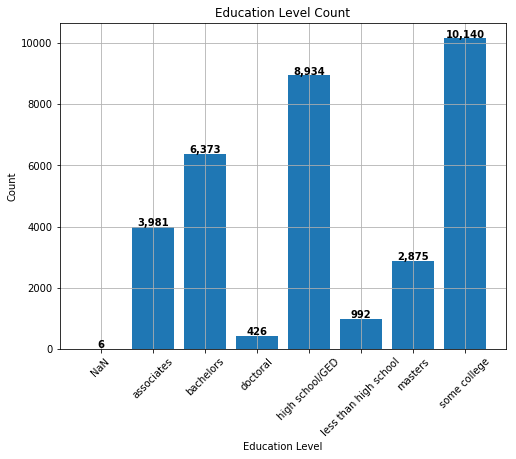

In [4]:
def plot_df(df):
    x = []
    y = []

    # Get the number of occurence of each unique class in our education list
    educ_count = df.groupby(['education']).count()['content']
    educ_list = list(sorted(df['education'].unique()))
    
    # Store it in x and y for easier use later
    for educ in educ_list:
        x.append(educ)
        y.append(educ_count[educ])

    # Set figure size
    plt.figure(figsize = (8,6))
    # Set plot title
    plt.title("Education Level Count")
    # Set x label
    plt.xlabel("Education Level")
    # Set y label
    plt.ylabel("Count")
    # Rotate the x labels so they don't look weird when they overlap
    plt.xticks(rotation=45)

    # Plot the bar graph of each label's frequency
    plt.bar(x, y)
    
    # Plot grid lines
    plt.grid()
    
    # Annotate the frequency at the top of each bar
    # x - which label id
    # y - heigh of bar graph, we add 35 to offset the text location
    # s - text
    # fontweight - make it bold or italic
    # horizontalalignment - alignment of text
    for idx, value in enumerate(y):
        plt.text(x = idx, y = value + 35, 
                 s = f"{value:,}", fontweight='bold', 
                 horizontalalignment='center')
        
    # Add more matplotlib code to your heart's desire to make it look cooler
    # But don't add too much

    # Show the graph
    plt.show()
    
plot_df(df)

## Cleaning Text Data

Machine learning models are very sensitive to imbalanced data. For an exaggerated example, imagine training a model to predict dogs and cats. If your training data has 99 images of dogs and only 1 image of a cat, your model will most likely overfit and only predict dogs and still get 99% accuracy.

We will filter and clean our data in preparation for the prediction and become a data janitor.

With our data collection process, some of the posts were repeated. They were either posted in different times or different locations. We'll take a look at all data points that aren't unique in the `content` column.

In [5]:
df[df.duplicated(subset = 'content')].head(10)

,content,education
10,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
11,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
15,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
22,Hello my name is Adrian I am 23 years old I am...,high school/GED
75,"Hello,\r\nMy name is Ronnie I've been a MA for...",some college
76,"Hello,\r\nMy name is Ronnie I've been a MA for...",some college
77,"Hello,\r\nMy name is Ronnie I've been a MA for...",some college
82,I'm an independent contractor in IT industry s...,bachelors
88,"Hello, my name is Andres Alvarado. I am an art...",high school/GED
104,I am low voltage tech with experience in secur...,some college


Notice that some of the data points were posted at different times or region. However, we only need one instance of that data. So we'll go ahead and remove all documents that have duplicates and keep the first occurance.

In [6]:
df.drop_duplicates(subset = 'content', keep = 'first', inplace = True)
df.reset_index(drop = True, inplace = True) #reset index just makes it cleaner to look at when all processing is done

In [7]:
df.sample(10)

,content,education
4736,"Hello,\r\n\r\nI am posting because I am seekin...",bachelors
812,Recent Marketing student seeking the right sum...,bachelors
488,I am a caregiver seeking a private paid job.I ...,some college
1284,Looking to breathe a little better and underst...,associates
2460,my fiance and I have many years of experience ...,associates
4969,"Christopher Green\r\nBoston, MA\r\n\r\nAuthori...",high school/GED
8663,My husband and I are looking for Any Cash Paid...,high school/GED
5168,Hello I am a housekeeper looking for work.\r\n...,high school/GED
3340,I’m a very dependable electrician with many ye...,associates
8736,I'm a hard and honest worker I can learn quick...,high school/GED


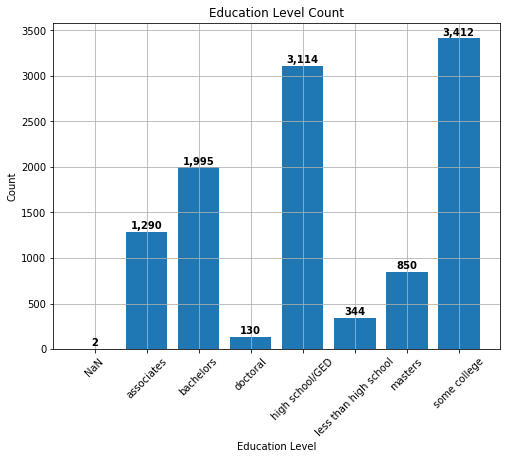

In [8]:
plot_df(df)

We reduced the amount of data tha we have to about 1/3. We can see that some of the labels only have a few data points. There are several ways to address imbalance datasets such as upsampling or downsampling. However for this exercise, we will ignore it and only use labels that have at least 500 samples.

In [9]:
# List out education levels that we will include
included_educ_level = ['high school/GED',
                       'some college',
                       'associates',
                       'bachelors',
                       'masters']

# Filter out our data and only include samples that are in the selected education levels
df = df[df['education'].isin(included_educ_level)].reset_index(drop = True)

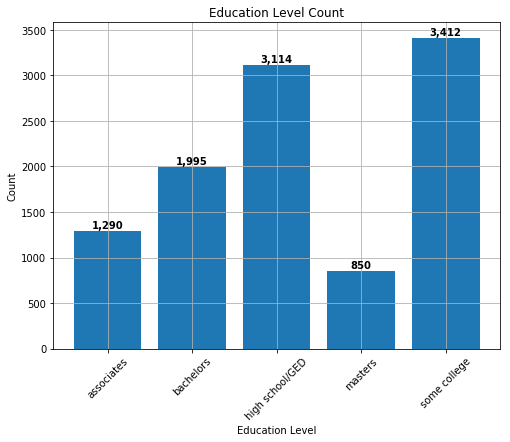

In [10]:
plot_df(df)

Okay so the distribution seems good enough for our use case. Let's try to take a look at the text and see if we need more preprocessing for it.

In [11]:
df['content'].sample(10, random_state = 237)

6792     I am looking for a new home. Due to financial ...
10484    I am looking for a flexible work at home posit...
7297     Hi my name is Jameel 6’3 220 Graduate from uni...
10631    🔥 ❗❗❗ATTENTION❗❗❗🔥\r\n\r\n🔥💗 I WILL ONLY BE LE...
6257     Hi,\r\n\r\nI am available for housekeeping/cle...
6511     My name is Mark,\r\nI install ceiling fans, li...
6087     If you’re looking to self-publish a book, eith...
2714     I currently hold over 15 years in logistics an...
1379     Hello,\r\n\r\nMy name is Nick and I have a rel...
9199     I offer a dental/vision and more program. It w...
Name: content, dtype: object

Looks like some of the posts have emojis or weird characters in their text. We can do a simple regex function to filter out each text in the dataframe and replace it with only alphanumeric characters.

Let's break down the regex function: <br />
`re.sub(pattern, repl, string)` <br /> <br />
`pattern` is the regular expression that the function will look for to replace. <br />
`repl` is the new string that will replace the `pattern` <br />
`string` is the string that you want to run the pattern matching and replacement.

Now, let's break down the regular expression. <br />
`[^A-Za-z0-9 _.,?!/$]*` <br />
`[]` anything inside the square brace will be characters that will be considered in replacement<br />
`^` Performs a `not` function. We will list down all the characters that we want to keep and perform `not` to take out those that don't match.<br />
`A-Z` All uppercase letters<br />
`a-z` All lowercase characters<br />
`0-9` All numerical characters<br />
` _.,?!/` Space, underscore, period, and other punctuations that we want to keep.<br />
`*` The length of the pattern doens't matter as long as each character matches the criterion.

In [12]:
df['content'] = df['content'].map(lambda x: re.sub('[^A-Za-z0-9 _.,?!/$]*', '', x))
df['content'].sample(10, random_state = 237)

6792     I am looking for a new home. Due to financial ...
10484    I am looking for a flexible work at home posit...
7297     Hi my name is Jameel 63 220 Graduate from univ...
10631     ATTENTION I WILL ONLY BE LETTING 100 PEOPLE I...
6257     Hi,I am available for housekeeping/cleaning/pa...
6511     My name is Mark,I install ceiling fans, light ...
6087     If youre looking to selfpublish a book, either...
2714     I currently hold over 15 years in logistics an...
1379     Hello,My name is Nick and I have a reliable tr...
9199     I offer a dental/vision and more program. It w...
Name: content, dtype: object

One thing that machine learning models don't intuitively know is the difference in cases. For us, `attention` is the same as `Attention` or `ATTENTION`. In a bag of words model, this will be separated into 3 different tokens. What we can do is to make every text lowercase to keep it standardized.

You can add the `.lower()` at the end of a string to convert it to lower case. Another solution is to use `.upper()` to make it all upper case but that would sound like an internet argument.

In [13]:
df['content'] = df['content'].map(lambda x: x.lower())
df['content'].sample(10, random_state = 237)

6792     i am looking for a new home. due to financial ...
10484    i am looking for a flexible work at home posit...
7297     hi my name is jameel 63 220 graduate from univ...
10631     attention i will only be letting 100 people i...
6257     hi,i am available for housekeeping/cleaning/pa...
6511     my name is mark,i install ceiling fans, light ...
6087     if youre looking to selfpublish a book, either...
2714     i currently hold over 15 years in logistics an...
1379     hello,my name is nick and i have a reliable tr...
9199     i offer a dental/vision and more program. it w...
Name: content, dtype: object

In most cases, this preprocessing is enough to process your data and use in a machine learning model.

# Classification

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import graphviz

## FEATURES

### Bag of Words

<img src="./../assets/images/bow-image.png" style="width: 300px;">

A bag-of-words model puts every word in your document into a bag (vector) and returns the bag. The most common bag of words model is the count vectorizer where you count each occurence of a word in a document. The visual above represents the count vectorizer. It's easy to use however this removes the sentence structure of the document.


In [15]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df['content'])

## LABELS

### Label Encoding
We will convert each label into a numerical index. From 'highschool', 'college', and 'masters', we will convert it to '0', '1', and '2'.

In [16]:
encoder = LabelEncoder()
target = encoder.fit_transform(df['education'])

target = pd.DataFrame({'education':df['education'].values,
                       'target':target})
target.sample(10)

,education,target
10437,some college,4
6666,some college,4
1222,associates,0
2820,high school/GED,2
2365,high school/GED,2
4811,bachelors,1
975,associates,0
4603,masters,3
3205,associates,0
3280,bachelors,1


Now let's write out the code.

In [17]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df['content'])
# Create list of feature index to token
token_list = {b:a for a,b in vector.vocabulary_.items()}

In [18]:
sorted_tokens = []
for a in sorted(token_list):
    sorted_tokens.append(token_list[a])

In [19]:
encoder = LabelEncoder()

target = encoder.fit_transform(df['education'])
# Get the list of labels
labels = list(encoder.classes_)

To train our model, we'll split the data into a training and test set. We train the model on our training data and validate the performance of the model on our test set.

For our neural network, we'll split the data into training, validation, and test set. The validation set will be used as a way to validate checkpoints in our neural network training to prevent overfitting.

In [20]:
X_train_full, X_test, y_train_full, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.25)

## Decision Tree

<img src="./../assets/images/decision_tree.png" style="width: 600px;">

Decision Trees are created by the data into groups based on which feature can differentiate each node. You can change the parameters of the decision tree such as the maximum depth of the tree and the minimum samples in a node before it can be split.

In [41]:
clf = DecisionTreeClassifier(max_depth = 20,
                             min_samples_split = 10,
                             criterion = 'entropy')

In [42]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

We can check how well our model performed both in the training and test data.

In [43]:
train_score = clf.score(X_train_full, y_train_full)
test_score  = clf.score(X_test, y_test)

print(f"Training score:\t{train_score*100:.2f}%")
print(f"Testing score:\t{test_score*100:.2f}%")

Training score:	51.13%
Testing score:	36.71%


We can also retrieve the most important features from the data.

In [44]:
print("Top 10 most important features:")
for a in np.argsort(clf.feature_importances_)[::-1][:10]:
    print(" -",token_list[a])

Top 10 most important features:
 - business
 - design
 - professional
 - degree
 - work
 - students
 - job
 - looking
 - experience
 - com


In [45]:
def get_prediction(text):
    sample_vec = vector.transform([text])
    predict = clf.predict(sample_vec)
    predict_class = encoder.inverse_transform(predict.astype(int))
    
    print(text,"\n")
    print(f"Predict:\t{predict_class[0]}")

get_prediction(df['content'].iloc[5])
print(f"Truth \t\t{df['education'].iloc[5]}")

reliable well organized professional with strong leadership qualities. committed to producing results above and beyond what is expected. strong in conflict resolutions. your company will love to have an enthusiastic, discipline, knowledgeable  fast learner employee like me. available immediately. fulltime job offer desirable.my career expertise areas are customer service customer satisfaction salesperson administrative assistant human resources assistant human resources specialist shift supervisor management law enforcement/security specialisti believe that i would be an assets to your company because my relevant knowledge, skills and abilities for this job includes1. bilingual spanish  english2. clerical skills3. microsoft office suite4. high stress environment5. high degree of initiative6. proven leadership7. integrity8. problem solving9. high degree of initiativeover 15 years career in law enforcement with a successfully approved mba in human resources. 

Predict:	associates
Truth 	

With the new update in scikit learn, you can now create pdfs of the tree generated by your model.

We would need to download graphviz, export the file, and set it as one of our PATH variables below.</br>
https://www.graphviz.org/download/

In [46]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/graphviz/release/bin'

dot_data = tree.export_graphviz(clf, out_file=None, feature_names = sorted_tokens) 
graph = graphviz.Source(dot_data) 
graph.render("nlp") 

'nlp.pdf'

## Neural Network
<img src="./../assets/images/nn.jpg" style="width: 600px;">

The Neural Network is a series of layers of nodes that are connected. The model learns by updating its parameters based on 'how wrong' the model is. Model training follows this series of steps:<br/>
- Model predicts the output
- Calculate the loss
- Propagate the loss through the entire network
- Update the weights
- Repeat

For this exercise, we will be using PyTorch.

In [27]:
import numpy as np

import torch
import torchvision

from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils

We first need to check if a GPU is available.

In [28]:
cuda = torch.cuda.is_available()

if cuda:
    print("GPU detected. Training with GPU")
else:
    print("No GPU detected. Training with CPU")

GPU detected. Training with GPU


PyTorch uses its own data structure called Tensor (which is similar to how other deep learning frameworks call it). We need to convert our data to Tensors.

In [29]:
tensor_X_train = torch.stack([torch.Tensor(row.todense()) for row in X_train])
tensor_y_train = torch.tensor(y_train)

tensor_X_valid = torch.stack([torch.Tensor(row.todense()) for row in X_valid])
tensor_y_valid = torch.tensor(y_valid)

tensor_X_test = torch.stack([torch.Tensor(row.todense()) for row in X_test])
tensor_y_test = torch.tensor(y_test)

We then load the our data into a data loader that will create the mini-batches that we will feed into our network.

In [30]:
traindataset = utils.TensorDataset(tensor_X_train, tensor_y_train)
trainloader = utils.DataLoader(traindataset, batch_size = 32, shuffle = True)

validdataset = utils.TensorDataset(tensor_X_valid, tensor_y_valid)
validloader = utils.DataLoader(validdataset, batch_size = 32, shuffle = True)

testdataset = utils.TensorDataset(tensor_X_test, tensor_y_test)
testloader = utils.DataLoader(testdataset, batch_size = 32)

Now, we can define our neural network! To build a simple neural network class, we need to define the `__init__` and `forward` function. <br/>

In the `__init__` function, we define the layers and processes of our network: <br/>

`nn.Linear()` is the hidden layer in the neural network. It takes in the input and output size. We create 3 different hidden layers. Notice that the first hidden layer's input size is equivalent to the number of features in our data. The last hidden layer has output size equivalent to the number of classes of our data.  <br/>
`nn.Dropout()` is a function that randomly turns off certain nodes. With this, the model becomes more robust and less prone to overfit.

In the `forward` function, we define how our model intakes, calculates, and outputs our data. There are 2 functions that we introduce here as well:<br/>

`F.relu()` performs the activation function ReLU (Rectified Linear Unit) on our model.<br/>
`F.log_softmax()` returns the LogSoftmax of the output and returns the class probabilty.

In [31]:
# Model must always inherit the nn.Module class
class Classifier(nn.Module):
    # Define the init function
    def __init__(self):
        super().__init__()
        
        # Create the first hidden layer with input 10,000 and output 2,000
        self.fc1 = nn.Linear(10000, 2000)
        # Create the second hidden layer with input 2,000 and output 500
        self.fc2 = nn.Linear(2000, 500)
        # Create the third hidden layer with input 500 and output 5
        self.fc3 = nn.Linear(500, 5)
        
        # Define the dropout function
        self.drop = nn.Dropout(0.5)
        
    # Define the forward function
    def forward(self, x):
        # Reshape the data
        x = x.view(x.shape[0], -1)
        # Feed the input data to the first hidden layer, apply dropout, and then apply the ReLU activation
        x = F.relu(self.drop(self.fc1(x)))
        # Same process as applies but using the second hidden layer
        x = F.relu(self.drop(self.fc2(x)))
        # Feed the features into the last hidden layer and feed it to a log soft max
        x = F.log_softmax(self.fc3(x), dim = 1)
        # Return output
        return x

Now that the model has been defined, we now need to define the loss function for our model and the optimizer.<br/>

The `loss function` calculates 'how wrong' our model is based on the ground truth values. In our example, we will use the __Negative Loss Likelihood function__.<br/>
The `optimizer` defines how you calculate the gradients that will update the neural network parameters. __Adam__ is one of the popular optimizers.

In [32]:
# Instantiate our model
model = Classifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define our optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

Next we will define our training loop. The training loop will run over n number of epochs. Earlier, we mentioned that neural networks tend to overfit the data, which is why we add a validation set in our training. The validation set is similar to the test set where we select the model that has the highest validation set. The difference between the validation and test set is the model never went through the test set. Since we're selecting our model based on the validation set, the validation set is, in a way, a bias in our model.

In [33]:
# Define how many epochs we want
epochs = 10

# Set the best loss as infinity and best_model as none
best_loss = np.inf
best_model = None

# Create empty arrays for our training losses for analysis
train_losses = []
valid_losses = []

# If we are using a GPU, import the model to the GPU
if cuda:
    model = model.cuda()
    
# Training loop
for e in range(epochs):
    # Set training loss for this epoch as 0
    train_loss = 0.
    
    # Set the model to `train` mode
    # This will let the functions that are important in training but
    # not validation to activate (i.e. Dropouts)
    model.train()
    
    # Loop for the mini batches using our dataloader
    for feat, labels in trainloader:
        # If we are using a GPU, move the features and the labels to the GPU
        if cuda:
            feat, labels = feat.cuda(), labels.cuda()
            
        # Get the output of the model
        log_ps = model(feat)
        
        # Calculate the loss for this mini batch size
        loss = criterion(log_ps, labels.long())
        
        # Zero out the gradients. By default, the gradients accumulate
        # which is convenient for RNNs
        optimizer.zero_grad()
        
        # Propage the loss to our model
        loss.backward()
        
        # Update our models weights
        optimizer.step()
        
        # Get the training loss for this mini batch
        train_loss += loss.item()
        
    # Get the average training loss for the entire training data for this epoch
    train_loss /= len(trainloader)
    train_losses.append(train_loss)
    
    ####################
    #### VALIDATION ####
    ####################
    
    # Set the valid loss
    valid_loss = 0.
    
    # Turn the model to eval mode so dropouts are turned off
    model.eval()
    
    # Loop for the validation set
    for feat, labels in validloader:
        # Move to GPU
        if cuda:
            feat, labels = feat.cuda(), labels.cuda()
        
        # Calculate predictions
        log_ps = model(feat)
        
        # Get loss function
        loss = criterion(log_ps, labels.long())
        
        # Get the loss for the mini batch
        valid_loss += loss.item()
        
        # Notice that we didn't zero out the gradients, propagate the loss
        # nor did we update the weights. The validation loop is merely for
        # evaluating the performance of our model
        
    # Get the average validation loss
    valid_loss /= len(validloader)
    valid_losses.append(valid_loss)
    
    # Print the training loss and validation loss of this epoch
    print(f"Epoch {e}: Training loss: \t{train_loss:.6f}\tValid loss: \t\t{valid_loss:.6f}")
    
    # If the validation loss improved, we save the model as the best model
    if valid_loss < best_loss:
        print("Validation loss improved... Saving model")
        best_loss = valid_loss
        best_model = model

model = best_model

Epoch 0: Training loss: 	1.413252	Valid loss: 		1.293277
Validation loss improved... Saving model
Epoch 1: Training loss: 	1.102110	Valid loss: 		1.290811
Validation loss improved... Saving model
Epoch 2: Training loss: 	0.726396	Valid loss: 		1.513098
Epoch 3: Training loss: 	0.427738	Valid loss: 		1.852523
Epoch 4: Training loss: 	0.246250	Valid loss: 		2.157980
Epoch 5: Training loss: 	0.137762	Valid loss: 		2.513967
Epoch 6: Training loss: 	0.111695	Valid loss: 		2.648295
Epoch 7: Training loss: 	0.090243	Valid loss: 		3.004183
Epoch 8: Training loss: 	0.069674	Valid loss: 		2.909761
Epoch 9: Training loss: 	0.108452	Valid loss: 		3.016269


Now, if you have a GPU, you can make a cup of coffe while you wait for the training loop. If you don't, might be good time watch an episode of a series you've been following.

Afterwards, we'll plot and see our training and validation loss.

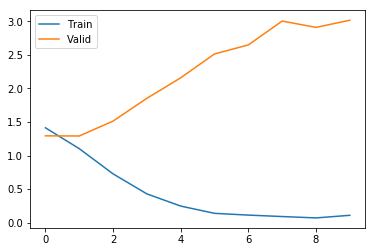

In [34]:
plt.plot(train_losses, label = 'Train')
plt.plot(valid_losses, label = 'Valid')
plt.legend()
plt.show()

In [35]:
def model_predict(text, model):
    # Convert our text to the vector representation
    if type(text) == str:
        text = vector.transform([text])
    # Convert it into a torch Tensor
    text = torch.Tensor(text.todense())
    # Move to GPU if you have GPU
    if cuda:
        model = model.cuda()
        text = text.cuda()
        
    # Predict probabilities
    predict = model(text)
    # Move the predictions to cpu
    predict = predict.cpu().detach().numpy()[0]
    # Get the prediction with highest probability
    predict = predict.argmax()
    return predict

model_predict("I have a degree", model)

0

Now we have a working model. Let's see it's accuracy in the training and test data.

In [36]:
correct_count = 0
for feat, val in tqdm(zip(X_train, y_train), total = len(y_train)):
    if model_predict(feat, model) == val:
        correct_count += 1

print(f"Model train accuracy: {correct_count*100/len(y_train):.2f}%")

correct_count = 0
for feat, val in tqdm(zip(X_test, y_test), total = len(y_test)):
    if model_predict(feat, model) == val:
        correct_count += 1

print(f"Model test accuracy: {correct_count*100/len(y_test):.2f}%")

100%|█████████████████████████████████████████████████████████████████████████████| 6396/6396 [00:08<00:00, 728.19it/s]


Model train accuracy: 99.58%


100%|█████████████████████████████████████████████████████████████████████████████| 2133/2133 [00:02<00:00, 716.29it/s]


Model test accuracy: 43.46%


It's a lot to take in. Luckily, scikit-learn has very simple implementation. MLPClassifier is short for Multi Layer Perceptron Classifier which is another term for the simple feed forward neural network.

In [37]:
from sklearn.neural_network import MLPClassifier

In [38]:
mlp = MLPClassifier(hidden_layer_sizes = (2000, 500),
                    activation = 'relu',
                    solver = 'adam',
                    batch_size = 32,
                    learning_rate_init = 0.0003,
                    max_iter = 10,
                    shuffle = True,
                    verbose = 1)

In [ ]:
mlp.fit(X_train, y_train)

In [40]:
mlp.score(X_test, y_test)

0.4481950304735115